In [17]:
# Import required libraries
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification
import faiss
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading and Preprocessing

In [18]:
print("Loading PubMedQA dataset...")
pubmedqa = load_dataset("pubmed_qa", "pqa_labeled", split="train")

# Convert to DataFrame for easier handling
df = pd.DataFrame({
    "question": pubmedqa["question"],
    "context": [' '.join(list(ctx.values())[0]) for ctx in pubmedqa["context"]],
    "answer": pubmedqa["final_decision"]
})

print(f"Dataset size: {len(df)}")
print("\nSample data:")
print(df.head(2))

Loading PubMedQA dataset...
Dataset size: 1000

Sample data:
                                            question  \
0  Do mitochondria play a role in remodelling lac...   
1  Landolt C and snellen e acuity: differences in...   

                                             context answer  
0  Programmed cell death (PCD) is the regulated d...    yes  
1  Assessment of visual acuity depends on the opt...     no  


# Document Processing following LongRAG paper

In [19]:
def create_document_chunks(text, chunk_size=200, overlap=50):
    """
    Create overlapping chunks from document following LongRAG's local view approach
    
    Key concepts from paper:
    1. Overlapping chunks to maintain context
    2. Both short and long chunks for different granularity
    """
    words = text.split()
    chunks = []
    # Short chunks for detailed local view
    for i in range(0, len(words), chunk_size - overlap):
        chunk = ' '.join(words[i:i + chunk_size])
        chunks.append(chunk)
    
    # Add longer chunks for broader context
    if len(words) > chunk_size * 2:
        longer_chunks = [
            ' '.join(words[:chunk_size * 2]),  # Start
            ' '.join(words[len(words)//2 - chunk_size:len(words)//2 + chunk_size]),  # Middle
            ' '.join(words[-chunk_size * 2:])  # End
        ]
        chunks.extend(longer_chunks)
    
    return chunks

def get_global_context(text, max_length=1000):
    """
    Extract global context following LongRAG's global view
    Includes document summary and key sections
    """
    words = text.split()
    # Take beginning and end of document for global context
    start_text = ' '.join(words[:max_length//2])
    end_text = ' '.join(words[-max_length//2:])
    return f"{start_text}... {end_text}"

# Model Initialization and Embedding Creation

In [20]:


# Initialize models
embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")

# Process documents and create embeddings
print("Creating document embeddings...")
all_chunks = []
global_contexts = []
chunk_to_doc_idx = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    # Create local chunks
    chunks = create_document_chunks(row['context'])
    all_chunks.extend(chunks)
    chunk_to_doc_idx.extend([idx] * len(chunks))
    
    # Create global context
    global_context = get_global_context(row['context'])
    global_contexts.append(global_context)

# Create embeddings for both views
local_embeddings = embedding_model.encode(all_chunks, show_progress_bar=True)
global_embeddings = embedding_model.encode(global_contexts, show_progress_bar=True)

# Create FAISS indices
dimension = local_embeddings.shape[1]
local_index = faiss.IndexFlatIP(dimension)
global_index = faiss.IndexFlatIP(dimension)

local_index.add(local_embeddings)
global_index.add(global_embeddings)

Creating document embeddings...


  0%|          | 0/1000 [00:00<?, ?it/s]

Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

# Core LongRAG Implementation

In [21]:

def retrieve_dual_perspective(question, top_k_global=3, top_k_local=5):
    """
    LongRAG's dual-perspective retrieval:
    1. Global view: Retrieve relevant documents
    2. Local view: Retrieve specific passages
    """
    question_embedding = embedding_model.encode([question])
    
    # Global retrieval
    _, global_indices = global_index.search(question_embedding, top_k_global)
    global_contexts_retrieved = [global_contexts[idx] for idx in global_indices[0]]
    
    # Local retrieval
    _, local_indices = local_index.search(question_embedding, top_k_local)
    local_chunks_retrieved = [all_chunks[idx] for idx in local_indices[0]]
    
    return global_contexts_retrieved, local_chunks_retrieved

def generate_answer_two_phase(question, local_chunks, global_context):
    """
    LongRAG's two-phase generation:
    1. Initial answer using local chunks
    2. Refinement using global context
    """
    # Phase 1: Generate from local chunks
    local_prompt = f"""Based on these specific passages, answer with 'yes', 'no', or 'maybe':
    
Passages: {' '.join(local_chunks[:3])}

Question: {question}
Initial answer:"""
    
    inputs = tokenizer(local_prompt, return_tensors="pt", max_length=1024, truncation=True)
    initial_outputs = model.generate(inputs.input_ids, max_length=50)
    initial_answer = tokenizer.decode(initial_outputs[0], skip_special_tokens=True)
    
    # Phase 2: Refine with global context
    refine_prompt = f"""Given the broader context, refine the previous answer.

Global context: {global_context}

Question: {question}
Initial answer: {initial_answer}

Final answer (yes/no/maybe):"""
    
    inputs = tokenizer(refine_prompt, return_tensors="pt", max_length=1024, truncation=True)
    final_outputs = model.generate(inputs.input_ids, max_length=50)
    final_answer = tokenizer.decode(final_outputs[0], skip_special_tokens=True).lower()
    
    # Clean final answer
    if 'yes' in final_answer:
        return 'yes'
    elif 'no' in final_answer:
        return 'no'
    else:
        return 'maybe'

# Complete Pipeline

In [22]:
def process_query(question):
    """Complete LongRAG pipeline"""
    # 1. Dual-perspective retrieval
    global_contexts, local_chunks = retrieve_dual_perspective(question)
    
    # 2. Two-phase answer generation
    final_answer = generate_answer_two_phase(question, local_chunks, global_contexts[0])
    
    return final_answer

# Evaluation function
def evaluate_model(num_samples=100):
    """
    Evaluate model with multiple metrics from the paper:
    1. Accuracy
    2. Retrieval precision
    3. Answer consistency
    """
    results = {
        'accuracy': [],
        'consistency': []
    }
    
    test_set = df.head(num_samples)
    for _, row in tqdm(test_set.iterrows(), total=len(test_set)):
        try:
            # Get multiple predictions to check consistency
            predictions = []
            for _ in range(3):
                pred = process_query(row['question'])
                predictions.append(pred)
            
            # Calculate metrics
            main_prediction = max(set(predictions), key=predictions.count)
            accuracy = int(main_prediction == row['answer'])
            consistency = len(set(predictions)) == 1
            
            results['accuracy'].append(accuracy)
            results['consistency'].append(consistency)
            
        except Exception as e:
            print(f"Error: {str(e)}")
            continue
    
    return {
        'final_accuracy': np.mean(results['accuracy']),
        'consistency': np.mean(results['consistency'])
    }

# Run evaluation
print("Running evaluation...")
eval_results = evaluate_model(num_samples=20)
print("\nEvaluation Results:")
print(f"Accuracy: {eval_results['final_accuracy']:.2f}")
print(f"Answer Consistency: {eval_results['consistency']:.2f}")

Running evaluation...


  0%|          | 0/20 [00:00<?, ?it/s]


Evaluation Results:
Accuracy: 0.55
Answer Consistency: 1.00


# Fine-tuning implementation

In [23]:

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import os

# Custom Dataset
class PubMedQADataset(Dataset):
    def __init__(self, data, tokenizer, max_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        prompt = f"Question: {item['question']} Context: {item['context']}"
        
        encoding = self.tokenizer(
            prompt,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        label_map = {'yes': 0, 'no': 1, 'maybe': 2}
        label = label_map[item['answer']]
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label)
        }

def fine_tune_model(save_dir='model_checkpoints', run_num=1):
    # Force CPU usage for stability
    device = torch.device('cpu')
    print(f"Using device: {device}")
    
    # Model parameters
    MODEL_NAME = "distilbert-base-uncased"
    BATCH_SIZE = 1
    MAX_SAMPLES = 100
    MAX_LENGTH = 128
    NUM_EPOCHS = 2
    
    print("Initializing model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
    model.to(device)
    
    # Prepare training data
    print("Preparing training data...")
    train_data = []
    for _, row in df.iloc[:MAX_SAMPLES].iterrows():
        global_context = get_global_context(row['context'])[:MAX_LENGTH]
        train_data.append({
            'question': row['question'],
            'context': global_context,
            'answer': row['answer']
        })
    
    # Split data
    train_size = int(0.8 * len(train_data))
    train_data, val_data = train_data[:train_size], train_data[train_size:]
    
    # Create datasets and dataloaders
    train_dataset = PubMedQADataset(train_data, tokenizer, max_length=MAX_LENGTH)
    val_dataset = PubMedQADataset(val_data, tokenizer, max_length=MAX_LENGTH)
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    # Training settings
    optimizer = AdamW(model.parameters(), lr=1e-5)
    
    # Training loop
    print(f"Starting fine-tuning run {run_num}...")
    best_accuracy = 0
    training_stats = []
    
    try:
        for epoch in range(NUM_EPOCHS):
            print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
            model.train()
            total_loss = 0
            correct = 0
            total = 0
            
            # Training
            for batch in tqdm(train_dataloader, desc=f"Training epoch {epoch+1}"):
                optimizer.zero_grad()
                
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids, 
                              attention_mask=attention_mask, 
                              labels=labels)
                
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                predictions = torch.argmax(outputs.logits, dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
                
                del outputs, loss
                gc.collect()
            
            train_accuracy = correct / total
            avg_loss = total_loss / len(train_dataloader)
            
            # Validation
            model.eval()
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for batch in tqdm(val_dataloader, desc="Validating"):
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    predictions = torch.argmax(outputs.logits, dim=1)
                    
                    val_correct += (predictions == labels).sum().item()
                    val_total += labels.size(0)
                    
                    del outputs
                    gc.collect()
            
            val_accuracy = val_correct / val_total
            
            print(f"Train Loss: {avg_loss:.4f}")
            print(f"Train Accuracy: {train_accuracy:.4f}")
            print(f"Validation Accuracy: {val_accuracy:.4f}")
            
            training_stats.append({
                'epoch': epoch + 1,
                'train_loss': avg_loss,
                'train_accuracy': train_accuracy,
                'val_accuracy': val_accuracy
            })
            
            # Save best model
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                torch.save(model.state_dict(), f'{save_dir}/best_model_run_{run_num}.pt')
                print(f"New best model saved! Accuracy: {val_accuracy:.4f}")
                
    except Exception as e:
        print(f"Error during training: {str(e)}")
        torch.save(model.state_dict(), f'{save_dir}/last_checkpoint_run_{run_num}.pt')
    
    return training_stats





In [24]:
# Run multiple fine-tuning iterations
os.makedirs('model_checkpoints', exist_ok=True)

all_runs_stats = []
NUM_RUNS = 3  # Number of times to run fine-tuning

for run in range(NUM_RUNS):
    print(f"\nStarting fine-tuning run {run+1}/{NUM_RUNS}")
    stats = fine_tune_model(run_num=run+1)
    all_runs_stats.append(stats)


Starting fine-tuning run 1/3
Using device: cpu
Initializing model and tokenizer...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\NLP_Final_Project\longrag_env\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Preparing training data...
Starting fine-tuning run 1...

Epoch 1/2




alidating: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.84it/s]

Train Loss: 1.0293
Train Accuracy: 0.5625
Validation Accuracy: 0.6000
New best model saved! Accuracy: 0.6000

Epoch 2/2




alidating: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.00it/s]

Train Loss: 0.9615
Train Accuracy: 0.5750
Validation Accuracy: 0.6000

Starting fine-tuning run 2/3
Using device: cpu
Initializing model and tokenizer...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preparing training data...
Starting fine-tuning run 2...

Epoch 1/2




alidating: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.09it/s]

Train Loss: 1.0086
Train Accuracy: 0.5750
Validation Accuracy: 0.6000
New best model saved! Accuracy: 0.6000

Epoch 2/2




alidating: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.88it/s]

Train Loss: 0.9449
Train Accuracy: 0.5750
Validation Accuracy: 0.6000

Starting fine-tuning run 3/3
Using device: cpu
Initializing model and tokenizer...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preparing training data...
Starting fine-tuning run 3...

Epoch 1/2




alidating: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.80it/s]

Train Loss: 1.0226
Train Accuracy: 0.5500
Validation Accuracy: 0.6000
New best model saved! Accuracy: 0.6000

Epoch 2/2




alidating: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.20it/s]

Train Loss: 0.9505
Train Accuracy: 0.5750
Validation Accuracy: 0.6000


# Visualisation

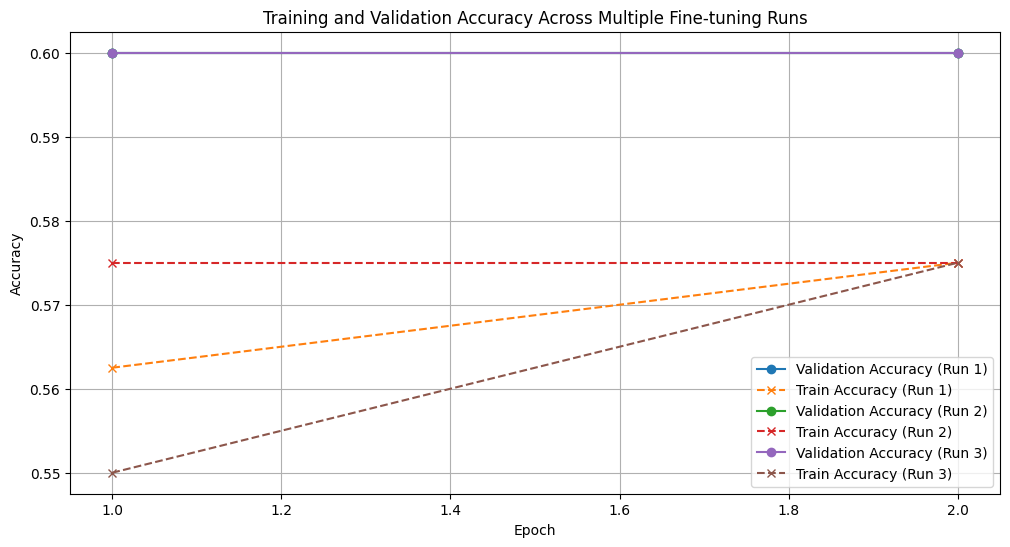


Best Validation and Training Accuracies:
Run 1 - Best Validation Accuracy: 0.6000, Best Training Accuracy: 0.5750
Run 2 - Best Validation Accuracy: 0.6000, Best Training Accuracy: 0.5750
Run 3 - Best Validation Accuracy: 0.6000, Best Training Accuracy: 0.5750


In [25]:
# Plot results from all runs
plt.figure(figsize=(12, 6))

for run, stats in enumerate(all_runs_stats):
    epochs = [stat['epoch'] for stat in stats]
    val_acc = [stat['val_accuracy'] for stat in stats]
    train_acc = [stat['train_accuracy'] for stat in stats]
    
    # Plot validation accuracy
    plt.plot(epochs, val_acc, marker='o', label=f'Validation Accuracy (Run {run+1})')
    # Plot training accuracy
    plt.plot(epochs, train_acc, marker='x', linestyle='--', label=f'Train Accuracy (Run {run+1})')

plt.title('Training and Validation Accuracy Across Multiple Fine-tuning Runs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Print best accuracy from each run
print("\nBest Validation and Training Accuracies:")
for run, stats in enumerate(all_runs_stats):
    best_val_acc = max(stat['val_accuracy'] for stat in stats)
    best_train_acc = max(stat['train_accuracy'] for stat in stats)
    print(f"Run {run+1} - Best Validation Accuracy: {best_val_acc:.4f}, Best Training Accuracy: {best_train_acc:.4f}")


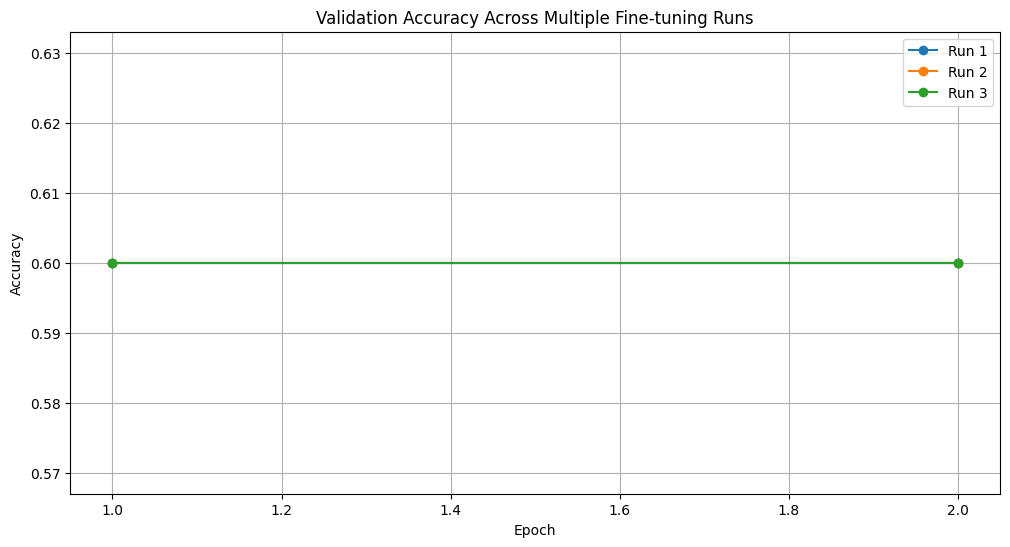


Best Validation Accuracies:
Run 1: 0.6000
Run 2: 0.6000
Run 3: 0.6000


In [26]:
# Plot results from all runs
plt.figure(figsize=(12, 6))

for run, stats in enumerate(all_runs_stats):
    epochs = [stat['epoch'] for stat in stats]
    val_acc = [stat['val_accuracy'] for stat in stats]
    plt.plot(epochs, val_acc, marker='o', label=f'Run {run+1}')

plt.title('Validation Accuracy Across Multiple Fine-tuning Runs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Print best accuracy from each run
print("\nBest Validation Accuracies:")
for run, stats in enumerate(all_runs_stats):
    best_acc = max(stat['val_accuracy'] for stat in stats)
    print(f"Run {run+1}: {best_acc:.4f}")

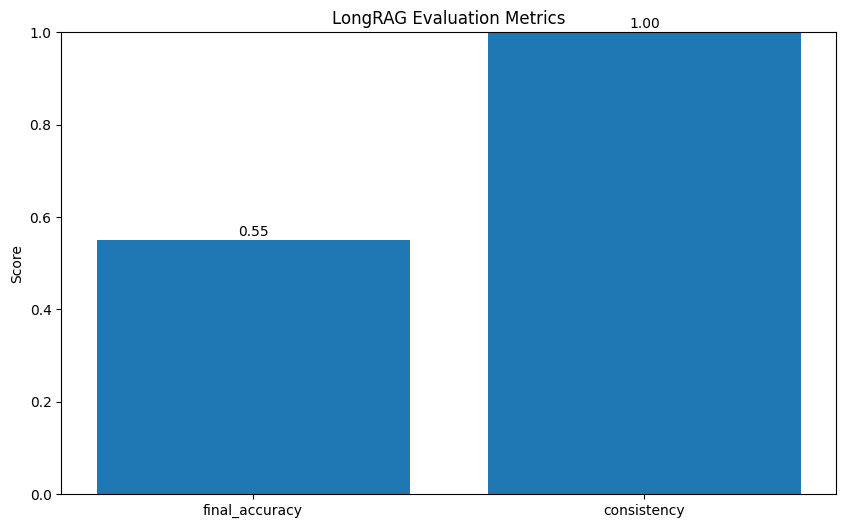

In [27]:
# Cell 8: Visualize results
import matplotlib.pyplot as plt

def plot_results(eval_results):
    metrics = list(eval_results.keys())
    values = list(eval_results.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values)
    plt.title('LongRAG Evaluation Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
    
    plt.show()

plot_results(eval_results)